<a href="https://colab.research.google.com/github/dslmllab/dSL-Lab-Coding-Challenge/blob/main/8_rnn_text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Text Generation: Creating Shakespeare-Style Text

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Understand RNN architecture** and its applications in sequence modeling
2. **Build character-level text generation models** using PyTorch
3. **Implement different RNN variants** (vanilla RNN, LSTM, GRU)
4. **Apply temperature sampling** for controlling text generation diversity
5. **Fine-tune models** for different writing styles and domains
6. **Evaluate text generation quality** using various metrics
7. **Understand the challenges** and limitations of neural text generation

## Introduction to RNN Text Generation

**Recurrent Neural Networks (RNNs)** are particularly well-suited for sequential data like text because they can maintain memory of previous inputs. In text generation, we train the network to predict the next character (or word) given the previous characters in the sequence.

### Why Shakespeare?
- **Rich linguistic patterns**: Shakespeare's works contain complex vocabulary and grammar
- **Distinctive style**: Easily recognizable writing patterns
- **Sufficient data**: Large corpus available for training
- **Cultural significance**: Widely known and appreciated

### Key Concepts:
- **Character-level modeling**: Predicting one character at a time
- **Hidden states**: Memory mechanism in RNNs
- **Temperature sampling**: Controlling randomness in generation
- **Sequence-to-sequence learning**: Learning patterns in sequential data

## 1. Setup and Imports

In [7]:
# Install required packages
!pip install numpy pandas matplotlib seaborn nltk torch tqdm scikit-learn unidecode requests

# Enable ipywidgets for Jupyter!

!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import random
import re
import time
import math
import unidecode
import requests
from collections import Counter
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style and random seeds for reproducibility
plt.style.use('default')
sns.set_palette("husl")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

%matplotlib inline

Using device: cpu


## 2. Data Loading and Preprocessing

In [9]:
def download_shakespeare_data():
    """Download Shakespeare text data"""
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"

    try:
        response = requests.get(url)
        with open('shakespeare.txt', 'w', encoding='utf-8') as f:
            f.write(response.text)
        print("Successfully downloaded Shakespeare data")
        return response.text
    except Exception as e:
        print(f"Error downloading data: {e}")
        # Fallback: create sample data
        sample_text = """
        HAMLET:
        To be, or not to be, that is the question:
        Whether 'tis nobler in the mind to suffer
        The slings and arrows of outrageous fortune,
        Or to take arms against a sea of troubles,
        And by opposing end them.

        MACBETH:
        Tomorrow, and tomorrow, and tomorrow,
        Creeps in this petty pace from day to day,
        To the last syllable of recorded time;
        And all our yesterdays have lighted fools
        The way to dusty death.
        """
        # Repeat sample text to make it longer
        sample_text = sample_text * 100
        with open('shakespeare.txt', 'w') as f:
            f.write(sample_text)
        return sample_text

# Download and load the data
text_data = download_shakespeare_data()

# Read the file and clean it
with open('shakespeare.txt', 'r', encoding='utf-8') as f:
    raw_text = f.read()

# Convert unicode to ASCII
text = unidecode.unidecode(raw_text)

print(f"Text length: {len(text):,} characters")
print(f"First 500 characters:\n{text[:500]}")

Successfully downloaded Shakespeare data
Text length: 1,115,394 characters
First 500 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


Total characters: 1,115,394
Unique characters: 65
Characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


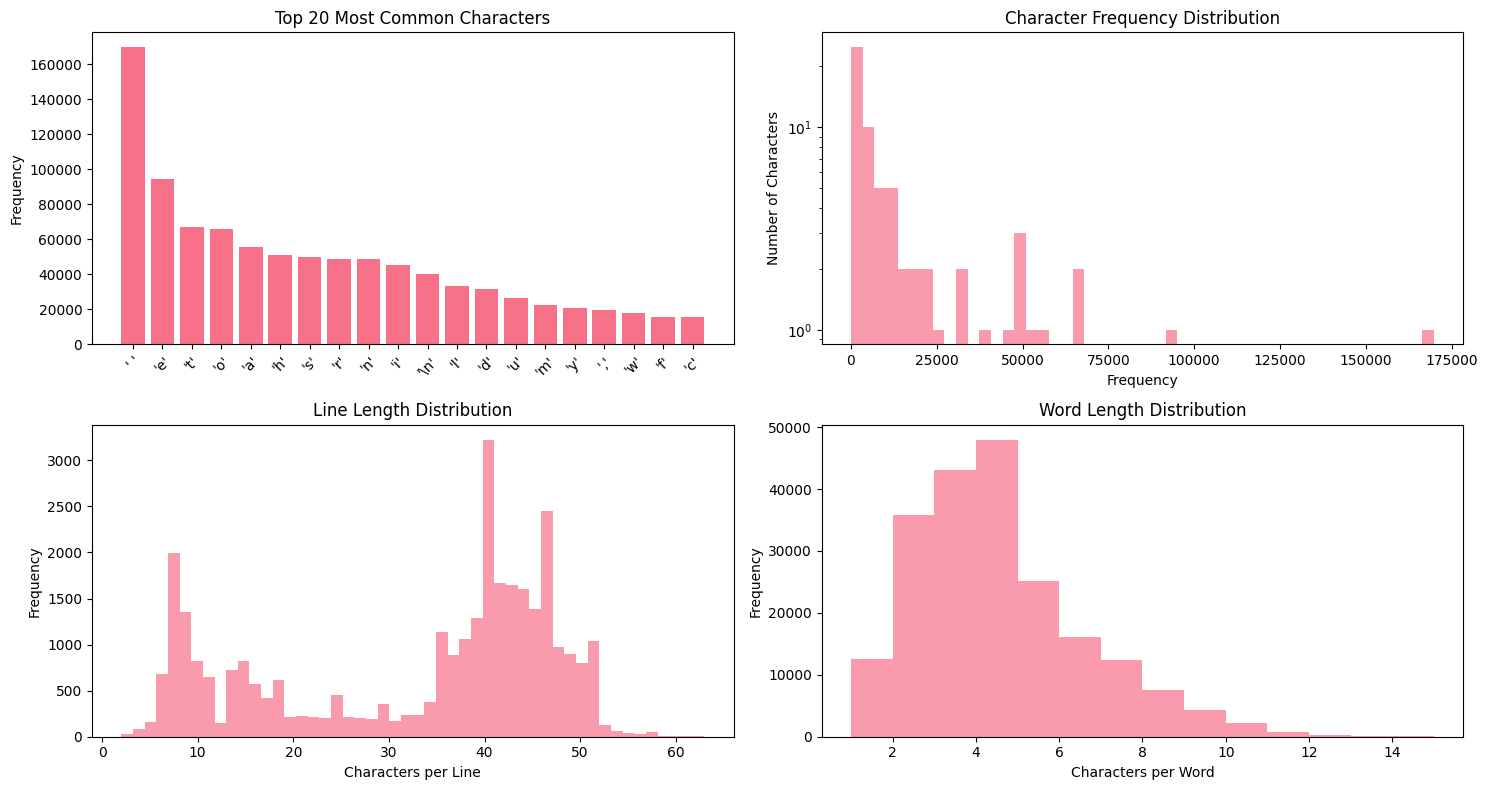

In [10]:
# Analyze the text
def analyze_text(text):
    """Analyze the text data"""
    chars = sorted(list(set(text)))
    char_counts = Counter(text)

    print(f"Total characters: {len(text):,}")
    print(f"Unique characters: {len(chars)}")
    print(f"Characters: {''.join(chars)}")

    # Character frequency analysis
    plt.figure(figsize=(15, 8))

    # Most common characters
    plt.subplot(2, 2, 1)
    common_chars = char_counts.most_common(20)
    chars_list, counts_list = zip(*common_chars)
    plt.bar(range(len(chars_list)), counts_list)
    plt.xticks(range(len(chars_list)), [repr(c) for c in chars_list], rotation=45)
    plt.title('Top 20 Most Common Characters')
    plt.ylabel('Frequency')

    # Character distribution
    plt.subplot(2, 2, 2)
    plt.hist([char_counts[c] for c in chars], bins=50, alpha=0.7)
    plt.title('Character Frequency Distribution')
    plt.xlabel('Frequency')
    plt.ylabel('Number of Characters')
    plt.yscale('log')

    # Line length analysis
    plt.subplot(2, 2, 3)
    lines = text.split('\n')
    line_lengths = [len(line) for line in lines if line.strip()]
    plt.hist(line_lengths, bins=50, alpha=0.7)
    plt.title('Line Length Distribution')
    plt.xlabel('Characters per Line')
    plt.ylabel('Frequency')

    # Word analysis
    plt.subplot(2, 2, 4)
    words = re.findall(r'\b\w+\b', text.lower())
    word_lengths = [len(word) for word in words]
    plt.hist(word_lengths, bins=range(1, max(word_lengths)+1), alpha=0.7)
    plt.title('Word Length Distribution')
    plt.xlabel('Characters per Word')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return chars, char_counts

chars, char_counts = analyze_text(text)

## 3. Data Preparation for Training

In [11]:
class TextDataset:
    """Dataset class for character-level text data"""

    def __init__(self, text, sequence_length=100):
        self.text = text
        self.sequence_length = sequence_length

        # Create character mappings
        self.chars = sorted(list(set(text)))
        self.char_to_idx = {char: i for i, char in enumerate(self.chars)}
        self.idx_to_char = {i: char for i, char in enumerate(self.chars)}

        self.vocab_size = len(self.chars)
        self.text_length = len(text)

        print(f"Dataset created:")
        print(f"  - Text length: {self.text_length:,} characters")
        print(f"  - Vocabulary size: {self.vocab_size} characters")
        print(f"  - Sequence length: {self.sequence_length}")
        print(f"  - Total sequences: {self.text_length - self.sequence_length:,}")

    def char_to_tensor(self, char):
        """Convert character to tensor"""
        return torch.tensor([self.char_to_idx[char]], dtype=torch.long).to(device)

    def string_to_tensor(self, string):
        """Convert string to tensor"""
        tensor = torch.zeros(len(string), dtype=torch.long)
        for i, char in enumerate(string):
            tensor[i] = self.char_to_idx[char]
        return tensor.to(device)

    def get_random_batch(self, batch_size=1):
        """Get random training batch"""
        inputs = []
        targets = []

        for _ in range(batch_size):
            start_idx = random.randint(0, self.text_length - self.sequence_length - 1)
            end_idx = start_idx + self.sequence_length + 1

            chunk = self.text[start_idx:end_idx]
            input_seq = self.string_to_tensor(chunk[:-1])
            target_seq = self.string_to_tensor(chunk[1:])

            inputs.append(input_seq)
            targets.append(target_seq)

        # Stack tensors
        inputs = torch.stack(inputs)
        targets = torch.stack(targets)

        return inputs, targets

    def tensor_to_string(self, tensor):
        """Convert tensor back to string"""
        if tensor.dim() > 1:
            tensor = tensor.squeeze()
        return ''.join([self.idx_to_char[idx.item()] for idx in tensor])

# Create dataset
dataset = TextDataset(text, sequence_length=100)

# Test the dataset
sample_input, sample_target = dataset.get_random_batch(batch_size=1)
print(f"\nSample input shape: {sample_input.shape}")
print(f"Sample target shape: {sample_target.shape}")
print(f"\nSample text: '{dataset.tensor_to_string(sample_input[0][:50])}'")
print(f"Target text:  '{dataset.tensor_to_string(sample_target[0][:50])}'")

Dataset created:
  - Text length: 1,115,394 characters
  - Vocabulary size: 65 characters
  - Sequence length: 100
  - Total sequences: 1,115,294

Sample input shape: torch.Size([1, 100])
Sample target shape: torch.Size([1, 100])

Sample text: 'BY:
Many good morrows to my noble lord!

HASTINGS:'
Target text:  'Y:
Many good morrows to my noble lord!

HASTINGS:
'


## 4. RNN Model Architectures

We'll implement multiple RNN architectures to compare their performance.

In [12]:
class CharRNN(nn.Module):
    """Character-level RNN for text generation"""

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1,
                 rnn_type='GRU', dropout=0.2):
        super(CharRNN, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn_type = rnn_type

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # RNN layer
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                              batch_first=True, dropout=dropout if num_layers > 1 else 0)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers,
                             batch_first=True, dropout=dropout if num_layers > 1 else 0)
        else:  # Vanilla RNN
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers,
                             batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Output layer
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        batch_size, seq_len = x.shape

        # Embedding
        x = self.embedding(x)

        # RNN
        if hidden is None:
            hidden = self.init_hidden(batch_size)

        rnn_out, hidden = self.rnn(x, hidden)

        # Apply dropout and linear layer
        rnn_out = self.dropout(rnn_out)

        # Reshape for linear layer
        rnn_out = rnn_out.reshape(-1, self.hidden_dim)
        output = self.fc(rnn_out)

        # Reshape back to (batch_size, seq_len, vocab_size)
        output = output.view(batch_size, seq_len, self.vocab_size)

        return output, hidden

    def init_hidden(self, batch_size):
        """Initialize hidden state"""
        if self.rnn_type == 'LSTM':
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
            return (h0, c0)
        else:
            return torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

# Test model creation
model = CharRNN(
    vocab_size=dataset.vocab_size,
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    rnn_type='GRU',
    dropout=0.3
).to(device)

print(f"Model created: {model.rnn_type}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test forward pass
test_input, test_target = dataset.get_random_batch(batch_size=2)
test_output, test_hidden = model(test_input)
print(f"\nTest shapes:")
print(f"Input: {test_input.shape}")
print(f"Output: {test_output.shape}")
print(f"Hidden: {test_hidden.shape if not isinstance(test_hidden, tuple) else test_hidden[0].shape}")

Model created: GRU
Total parameters: 716,225

Test shapes:
Input: torch.Size([2, 100])
Output: torch.Size([2, 100, 65])
Hidden: torch.Size([2, 2, 256])


## 5. Training Functions

In [13]:
def train_model(model, dataset, num_epochs=1000, learning_rate=0.002,
                batch_size=32, print_every=100, save_every=500):
    """Train the RNN model"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.8)

    model.train()
    losses = []
    start_time = time.time()

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Batch size: {batch_size}, Learning rate: {learning_rate}")

    for epoch in range(1, num_epochs + 1):
        # Get batch
        inputs, targets = dataset.get_random_batch(batch_size)

        # Forward pass
        hidden = model.init_hidden(batch_size)
        output, hidden = model(inputs, hidden)

        # Calculate loss
        loss = criterion(output.reshape(-1, dataset.vocab_size), targets.reshape(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()
        scheduler.step()

        losses.append(loss.item())

        # Print progress
        if epoch % print_every == 0:
            elapsed = time.time() - start_time
            avg_loss = sum(losses[-print_every:]) / print_every
            print(f'Epoch [{epoch}/{num_epochs}] - Loss: {avg_loss:.4f} - Time: {elapsed:.1f}s')

            # Generate sample text
            sample_text = generate_text(model, dataset, prime_str="To be",
                                      predict_len=100, temperature=0.8)
            print(f'Sample: "{sample_text[:80]}..."\n')

        # Save model
        if epoch % save_every == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
                'losses': losses
            }, f'checkpoint_epoch_{epoch}.pth')

    return losses

def generate_text(model, dataset, prime_str='A', predict_len=200, temperature=0.8):
    """Generate text using trained model"""
    model.eval()

    with torch.no_grad():
        # Initialize
        hidden = model.init_hidden(1)
        prime_input = dataset.string_to_tensor(prime_str).unsqueeze(0)
        predicted = prime_str

        # Use priming string to build up hidden state
        for p in range(len(prime_str) - 1):
            _, hidden = model(prime_input[:, p:p+1], hidden)

        # Start with last character of prime string
        inp = prime_input[:, -1:]

        # Generate characters
        for p in range(predict_len):
            output, hidden = model(inp, hidden)

            # Apply temperature
            output_dist = output[0, -1].div(temperature).exp()

            # Sample from distribution
            top_i = torch.multinomial(output_dist, 1)[0]

            # Add predicted character to string
            predicted_char = dataset.idx_to_char[top_i.item()]
            predicted += predicted_char

            # Use as next input
            inp = torch.tensor([[top_i]], dtype=torch.long).to(device)

    model.train()
    return predicted

def evaluate_model(model, dataset, num_samples=100):
    """Evaluate model performance"""
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0

    with torch.no_grad():
        for _ in range(num_samples):
            inputs, targets = dataset.get_random_batch(batch_size=1)
            hidden = model.init_hidden(1)
            output, hidden = model(inputs, hidden)

            loss = criterion(output.reshape(-1, dataset.vocab_size), targets.reshape(-1))
            total_loss += loss.item()

    avg_loss = total_loss / num_samples
    perplexity = math.exp(avg_loss)

    model.train()
    return avg_loss, perplexity

print("Training functions defined successfully!")

Training functions defined successfully!


## 6. Train the Model

In [14]:
# Create and train model
model = CharRNN(
    vocab_size=dataset.vocab_size,
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    rnn_type='GRU',
    dropout=0.3
).to(device)

print(f"Training {model.rnn_type} model with {sum(p.numel() for p in model.parameters()):,} parameters")

# Train the model
losses = train_model(
    model=model,
    dataset=dataset,
    num_epochs=1000,
    learning_rate=0.002,
    batch_size=32,
    print_every=100,
    save_every=500
)

Training GRU model with 716,225 parameters
Starting training for 1000 epochs...
Batch size: 32, Learning rate: 0.002
Epoch [100/1000] - Loss: 2.4358 - Time: 61.0s
Sample: "To beetien!

LUIO:
Now cave havous is the to spars bepace the cought
Pemam ead t..."

Epoch [200/1000] - Loss: 1.9299 - Time: 114.9s
Sample: "To beg
We the due is mone a ford conder
That the lide offford no dray.

HUCINII:..."

Epoch [300/1000] - Loss: 1.7859 - Time: 167.3s
Sample: "To be bound thy more in tut my brother bheet
not may true fare is unceal is the ..."

Epoch [400/1000] - Loss: 1.7148 - Time: 219.1s
Sample: "To be sorched much a nights and bestare;
The king-have him from a cheems and voi..."

Epoch [500/1000] - Loss: 1.6601 - Time: 272.4s
Sample: "To be me and cannot bear her land
With all the parting to the flattenso, my dles..."

Epoch [600/1000] - Loss: 1.6242 - Time: 324.8s
Sample: "To be a dhimp to make
Than this foot of the twentorant,
Martal hath smoves so my..."

Epoch [700/1000] - Loss: 1.5993 

## 7. Analyze Training Results

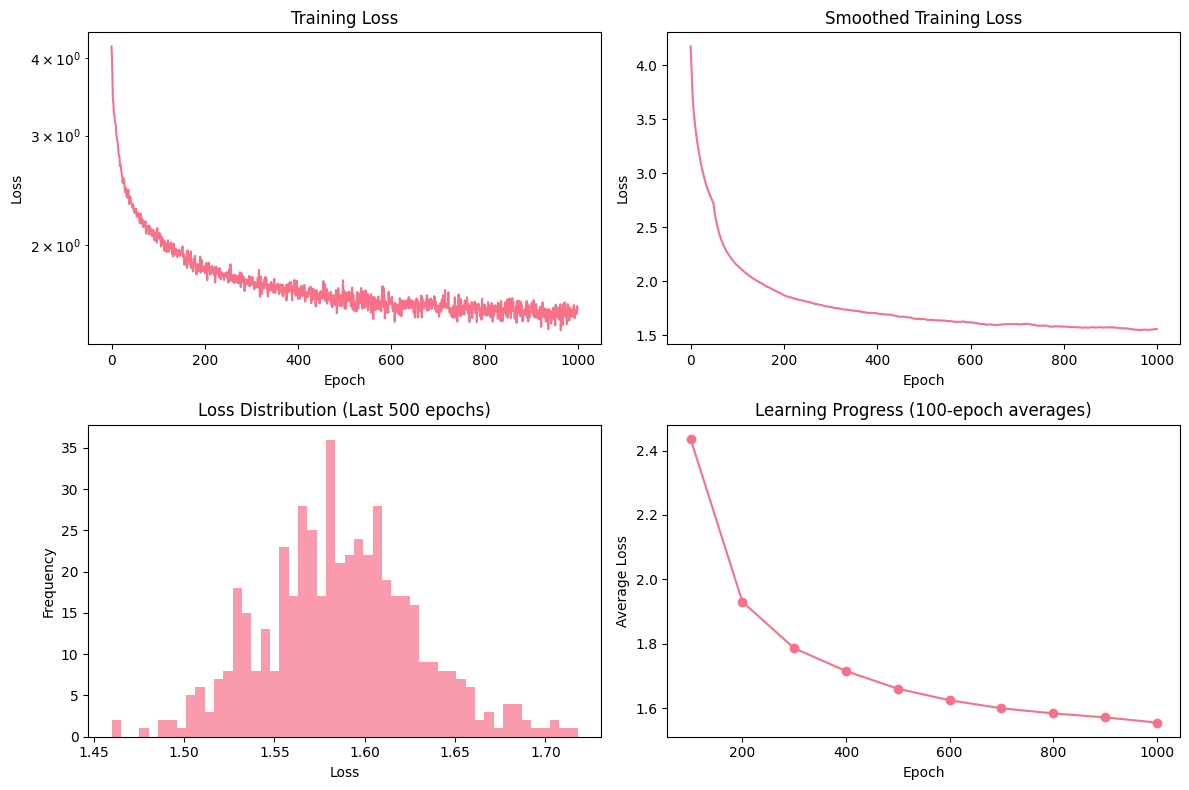


Final evaluation:
Average loss: 1.4175
Perplexity: 4.13


In [15]:
# Plot training loss
plt.figure(figsize=(12, 8))

# Loss curve
plt.subplot(2, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

# Smoothed loss curve
plt.subplot(2, 2, 2)
window_size = 50
smoothed_losses = []
for i in range(len(losses)):
    start = max(0, i - window_size + 1)
    smoothed_losses.append(sum(losses[start:i+1]) / (i - start + 1))

plt.plot(smoothed_losses)
plt.title('Smoothed Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Loss distribution
plt.subplot(2, 2, 3)
plt.hist(losses[-500:], bins=50, alpha=0.7)
plt.title('Loss Distribution (Last 500 epochs)')
plt.xlabel('Loss')
plt.ylabel('Frequency')

# Learning progress
plt.subplot(2, 2, 4)
epochs = list(range(100, len(losses)+1, 100))
epoch_losses = [sum(losses[i-100:i])/100 for i in epochs]
plt.plot(epochs, epoch_losses, 'o-')
plt.title('Learning Progress (100-epoch averages)')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')

plt.tight_layout()
plt.show()

# Evaluate final model
final_loss, perplexity = evaluate_model(model, dataset)
print(f"\nFinal evaluation:")
print(f"Average loss: {final_loss:.4f}")
print(f"Perplexity: {perplexity:.2f}")

## 8. Text Generation and Temperature Analysis

In [16]:
def compare_temperatures(model, dataset, prime_str="To be", predict_len=200):
    """Compare text generation with different temperatures"""
    temperatures = [0.2, 0.5, 0.8, 1.0, 1.2, 1.5]

    print(f"Comparing temperatures for prompt: '{prime_str}'\n")
    print("=" * 80)

    for temp in temperatures:
        generated = generate_text(model, dataset, prime_str, predict_len, temp)
        print(f"Temperature {temp}:")
        print(f"{generated}\n")
        print("-" * 80)

# Compare different temperatures
compare_temperatures(model, dataset, "HAMLET:", 150)

Comparing temperatures for prompt: 'HAMLET:'

Temperature 0.2:
HAMLET:
I have been a soldiers and the bear the world the world.

KING RICHARD III:
And the news and the seas of my soul and heart
That is the seas and the s

--------------------------------------------------------------------------------
Temperature 0.5:
HAMLET:
Ay the head and dead the vonces and the showers, and my day,
And so was not the cause what is he is a dispersed to him.

PAULINA:
I will be a fair al

--------------------------------------------------------------------------------
Temperature 0.8:
HAMLET:
My lord, not not such report you was to him.

HENRY BOLIGBERLY:
Why, I will gentle well of them my bept!

QUEEN ELIZABETH:
I, that your man have I re

--------------------------------------------------------------------------------
Temperature 1.0:
HAMLET:
I like it motrowned the counfess;
Ranking your mother toSenous, all;
And never near in a sance, if me: I
Fende as slike his himthes, obed.
Ay ong the

-------

In [17]:
def analyze_generation_diversity(model, dataset, prime_str="To be", num_samples=10, temperature=0.8):
    """Analyze diversity in generated text"""
    generations = []

    for i in range(num_samples):
        text = generate_text(model, dataset, prime_str, 100, temperature)
        generations.append(text)

    # Calculate diversity metrics
    all_chars = ''.join(generations)
    char_counts = Counter(all_chars)

    # Unique characters
    unique_chars = len(set(all_chars))

    # Calculate bigram diversity
    bigrams = [all_chars[i:i+2] for i in range(len(all_chars)-1)]
    unique_bigrams = len(set(bigrams))

    print(f"Generation Diversity Analysis (Temperature: {temperature})")
    print(f"Number of samples: {num_samples}")
    print(f"Total characters generated: {len(all_chars)}")
    print(f"Unique characters: {unique_chars}/{dataset.vocab_size} ({100*unique_chars/dataset.vocab_size:.1f}%)")
    print(f"Unique bigrams: {unique_bigrams}")

    # Show samples
    print(f"\nSample generations:")
    for i, gen in enumerate(generations[:3]):
        print(f"{i+1}. {gen[:80]}...")

    return generations, char_counts

# Analyze generation diversity
generations, char_counts = analyze_generation_diversity(model, dataset)

Generation Diversity Analysis (Temperature: 0.8)
Number of samples: 10
Total characters generated: 1050
Unique characters: 48/65 (73.8%)
Unique bigrams: 307

Sample generations:
1. To be the bloody bmanded to peace:
Welcoust these one from my hands, thated the ...
2. To be must a way,
And if have my want we will confess, I have the bears
Might no...
3. To bereft shall sun chardar;
For this eant make you, to the reverend him to umen...


## 9. Model Comparison

In [18]:
def compare_rnn_architectures(dataset, architectures=['RNN', 'GRU', 'LSTM'],
                              num_epochs=500, hidden_dim=128):
    """Compare different RNN architectures"""
    results = {}

    for arch in architectures:
        print(f"\nTraining {arch} model...")

        # Create model
        model = CharRNN(
            vocab_size=dataset.vocab_size,
            embedding_dim=64,
            hidden_dim=hidden_dim,
            num_layers=1,
            rnn_type=arch,
            dropout=0.2
        ).to(device)

        # Train model
        start_time = time.time()
        losses = train_model(
            model=model,
            dataset=dataset,
            num_epochs=num_epochs,
            learning_rate=0.002,
            batch_size=16,
            print_every=100
        )
        training_time = time.time() - start_time

        # Evaluate
        final_loss, perplexity = evaluate_model(model, dataset)

        # Generate sample
        sample_text = generate_text(model, dataset, "To be", 100, 0.8)

        results[arch] = {
            'model': model,
            'losses': losses,
            'final_loss': final_loss,
            'perplexity': perplexity,
            'training_time': training_time,
            'sample_text': sample_text,
            'num_params': sum(p.numel() for p in model.parameters())
        }

    # Compare results
    print("\n" + "="*80)
    print("ARCHITECTURE COMPARISON")
    print("="*80)

    comparison_df = []
    for arch, result in results.items():
        comparison_df.append({
            'Architecture': arch,
            'Parameters': f"{result['num_params']:,}",
            'Final Loss': f"{result['final_loss']:.4f}",
            'Perplexity': f"{result['perplexity']:.2f}",
            'Training Time': f"{result['training_time']:.1f}s"
        })

    import pandas as pd
    df = pd.DataFrame(comparison_df)
    print(df.to_string(index=False))

    # Plot comparison
    plt.figure(figsize=(15, 10))

    # Loss curves
    plt.subplot(2, 3, 1)
    for arch, result in results.items():
        plt.plot(result['losses'], label=arch)
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.yscale('log')

    # Final metrics
    architectures_list = list(results.keys())

    plt.subplot(2, 3, 2)
    final_losses = [results[arch]['final_loss'] for arch in architectures_list]
    plt.bar(architectures_list, final_losses)
    plt.title('Final Loss')
    plt.ylabel('Loss')

    plt.subplot(2, 3, 3)
    perplexities = [results[arch]['perplexity'] for arch in architectures_list]
    plt.bar(architectures_list, perplexities)
    plt.title('Perplexity')
    plt.ylabel('Perplexity')

    plt.subplot(2, 3, 4)
    training_times = [results[arch]['training_time'] for arch in architectures_list]
    plt.bar(architectures_list, training_times)
    plt.title('Training Time')
    plt.ylabel('Seconds')

    plt.subplot(2, 3, 5)
    num_params = [results[arch]['num_params'] for arch in architectures_list]
    plt.bar(architectures_list, num_params)
    plt.title('Number of Parameters')
    plt.ylabel('Parameters')

    plt.tight_layout()
    plt.show()

    # Show sample texts
    print("\nSample generated texts:")
    for arch, result in results.items():
        print(f"\n{arch}: {result['sample_text'][:100]}...")

    return results

# Note: This will take some time to run
# comparison_results = compare_rnn_architectures(dataset, num_epochs=300)
print("Architecture comparison function defined. Uncomment to run comparison.")

Architecture comparison function defined. Uncomment to run comparison.


## 10. Advanced Text Generation Techniques

In [19]:
def nucleus_sampling(model, dataset, prime_str='A', predict_len=200, top_p=0.9):
    """Generate text using nucleus (top-p) sampling"""
    model.eval()

    with torch.no_grad():
        hidden = model.init_hidden(1)
        prime_input = dataset.string_to_tensor(prime_str).unsqueeze(0)
        predicted = prime_str

        # Build up hidden state with prime string
        for p in range(len(prime_str) - 1):
            _, hidden = model(prime_input[:, p:p+1], hidden)

        inp = prime_input[:, -1:]

        for p in range(predict_len):
            output, hidden = model(inp, hidden)

            # Get probabilities
            probs = F.softmax(output[0, -1], dim=0)

            # Sort probabilities
            sorted_probs, sorted_indices = torch.sort(probs, descending=True)

            # Find cumulative probabilities
            cumsum_probs = torch.cumsum(sorted_probs, dim=0)

            # Find cutoff index
            cutoff_idx = torch.where(cumsum_probs > top_p)[0]
            if len(cutoff_idx) > 0:
                cutoff_idx = cutoff_idx[0].item()
            else:
                cutoff_idx = len(sorted_probs) - 1

            # Keep only top-p probabilities
            top_indices = sorted_indices[:cutoff_idx + 1]
            top_probs = sorted_probs[:cutoff_idx + 1]

            # Renormalize
            top_probs = top_probs / top_probs.sum()

            # Sample from top-p distribution
            sampled_idx = torch.multinomial(top_probs, 1)[0]
            selected_idx = top_indices[sampled_idx]

            # Add predicted character
            predicted_char = dataset.idx_to_char[selected_idx.item()]
            predicted += predicted_char

            inp = torch.tensor([[selected_idx]], dtype=torch.long).to(device)

    model.train()
    return predicted

def top_k_sampling(model, dataset, prime_str='A', predict_len=200, top_k=40):
    """Generate text using top-k sampling"""
    model.eval()

    with torch.no_grad():
        hidden = model.init_hidden(1)
        prime_input = dataset.string_to_tensor(prime_str).unsqueeze(0)
        predicted = prime_str

        # Build up hidden state with prime string
        for p in range(len(prime_str) - 1):
            _, hidden = model(prime_input[:, p:p+1], hidden)

        inp = prime_input[:, -1:]

        for p in range(predict_len):
            output, hidden = model(inp, hidden)

            # Get top-k values and indices
            top_k_values, top_k_indices = torch.topk(output[0, -1], top_k)

            # Convert to probabilities
            top_k_probs = F.softmax(top_k_values, dim=0)

            # Sample from top-k distribution
            sampled_idx = torch.multinomial(top_k_probs, 1)[0]
            selected_idx = top_k_indices[sampled_idx]

            # Add predicted character
            predicted_char = dataset.idx_to_char[selected_idx.item()]
            predicted += predicted_char

            inp = torch.tensor([[selected_idx]], dtype=torch.long).to(device)

    model.train()
    return predicted

# Compare different sampling methods
print("Comparing different sampling methods:")
print("\n1. Temperature sampling (0.8):")
temp_text = generate_text(model, dataset, "HAMLET:", 150, 0.8)
print(temp_text)

print("\n2. Top-k sampling (k=40):")
topk_text = top_k_sampling(model, dataset, "HAMLET:", 150, 40)
print(topk_text)

print("\n3. Nucleus sampling (p=0.9):")
nucleus_text = nucleus_sampling(model, dataset, "HAMLET:", 150, 0.9)
print(nucleus_text)

Comparing different sampling methods:

1. Temperature sampling (0.8):
HAMLET:
Alas, and well make gracious hands, af a grace my conperity mother:
Four dufness and commands a fame by the better's arms
And dained town upon your h

2. Top-k sampling (k=40):
HAMLET:
Must the price to send myself not gentles:
Your put not than
stay envart the melderegret o' thee.
Some hung against schoot would but the younstining 

3. Nucleus sampling (p=0.9):
HAMLET:
O for the grace is now; in a man's mother.

AUTOLYCUS:
Go, the wombrance and best more my world of them for his fits
And I know the great worthy in s


---

# Challenge Section



## Challenge 1: Word-Level Text Generation

Implement a word-level RNN instead of character-level.

**Tasks:**
1. Create a word-level dataset class
2. Handle vocabulary with unknown word tokens
3. Implement word-level RNN model
4. Compare word-level vs character-level generation
5. Analyze the trade-offs (vocabulary size, coherence, etc.)

In [20]:
# TODO: Implement word-level text generation
class WordDataset:
    def __init__(self, text, sequence_length=50, min_word_freq=2):
        """
        Create word-level dataset
        - Handle tokenization
        - Create vocabulary with UNK tokens
        - Implement word-to-index mapping
        """
        # Your implementation here
        pass

    def tokenize_text(self, text):
        """
        Tokenize text into words
        """
        # Your implementation here
        pass

    def build_vocabulary(self, words, min_freq):
        """
        Build vocabulary with frequency filtering
        """
        # Your implementation here
        pass

class WordRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2):
        super(WordRNN, self).__init__()
        # TODO: Implement word-level RNN
        pass

    def forward(self, x, hidden=None):
        # Your implementation here
        pass

# TODO: Compare word-level vs character-level performance
def compare_word_vs_char_generation():
    # Your implementation here
    pass

## Challenge 2: Advanced RNN Architectures

Implement and compare advanced RNN architectures.

**Tasks:**
1. Implement bidirectional RNN for better context understanding
2. Create attention mechanism for RNN
3. Implement residual connections in deep RNNs
4. Add layer normalization
5. Compare performance of different architectural improvements

In [21]:
# TODO: Implement advanced RNN architectures
class BidirectionalRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2):
        super(BidirectionalRNN, self).__init__()
        # TODO: Implement bidirectional RNN
        # Note: For generation, you'll need to use only forward direction
        pass

class AttentionRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2):
        super(AttentionRNN, self).__init__()
        # TODO: Implement attention mechanism
        pass

    def attention(self, hidden_states, current_hidden):
        """
        Implement attention mechanism
        """
        # Your implementation here
        pass

class ResidualRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=4):
        super(ResidualRNN, self).__init__()
        # TODO: Implement RNN with residual connections
        pass

class LayerNormRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2):
        super(LayerNormRNN, self).__init__()
        # TODO: Implement RNN with layer normalization
        pass

# TODO: Compare architectural improvements
def compare_advanced_architectures():
    # Your implementation here
    pass

## Challenge 3: Multi-Style Text Generation

Create a model that can generate text in different styles.

**Tasks:**
1. Collect texts from different authors/genres
2. Implement style-conditional generation
3. Create style embeddings
4. Implement style transfer between different writing styles
5. Evaluate style consistency and quality

In [22]:
# TODO: Implement multi-style text generation
class MultiStyleDataset:
    def __init__(self, texts_by_style, sequence_length=100):
        """
        Dataset that handles multiple text styles
        texts_by_style: dict mapping style_name -> text_content
        """
        # Your implementation here
        pass

    def get_style_batch(self, style, batch_size=1):
        """
        Get batch of sequences from specific style
        """
        # Your implementation here
        pass

class StyleConditionalRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim,
                 num_styles, style_embedding_dim=50, num_layers=2):
        super(StyleConditionalRNN, self).__init__()
        # TODO: Implement style-conditional RNN
        self.style_embedding = nn.Embedding(num_styles, style_embedding_dim)
        # Your implementation here
        pass

    def forward(self, x, style_ids, hidden=None):
        # TODO: Incorporate style information
        pass

def collect_multi_style_data():
    """
    Collect texts from different authors/styles
    """
    # TODO: Implement data collection from multiple sources
    # Consider: Shakespeare, Modern poetry, News articles, etc.
    pass

def generate_with_style(model, dataset, style, prime_str, length=200):
    """
    Generate text in specific style
    """
    # Your implementation here
    pass

def evaluate_style_consistency(model, dataset, style, num_samples=10):
    """
    Evaluate how consistently the model generates in given style
    """
    # Your implementation here
    pass

## Challenge 4: Interactive Text Generation

Build an interactive text generation system with real-time feedback.

**Tasks:**
1. Create interactive interface for text generation
2. Implement real-time parameter adjustment (temperature, top-k, etc.)
3. Add text completion and suggestion features
4. Implement user feedback mechanism to improve generation
5. Create visualization of model attention/decisions

In [23]:
# TODO: Implement interactive text generation system
import ipywidgets as widgets
from IPython.display import display, clear_output

class InteractiveTextGenerator:
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset
        self.generation_history = []

    def create_interface(self):
        """
        Create interactive widgets for text generation
        """
        # TODO: Create widgets for:
        # - Text input box for prime string
        # - Sliders for temperature, length, top-k
        # - Buttons for generate, save, clear
        # - Text area for output
        pass

    def generate_interactive(self, prime_str, length, temperature, top_k):
        """
        Generate text with interactive parameters
        """
        # Your implementation here
        pass

    def visualize_attention(self, text, attention_weights):
        """
        Visualize attention weights for generated text
        """
        # Your implementation here
        pass

    def collect_feedback(self, generated_text, user_rating):
        """
        Collect user feedback for improving generation
        """
        # Your implementation here
        pass

# TODO: Implement text completion system
def implement_text_completion(model, dataset):
    """
    Implement auto-completion suggestions
    """
    # Your implementation here
    pass

# Create interactive generator
# interactive_gen = InteractiveTextGenerator(model, dataset)
# interactive_gen.create_interface()
print("Interactive text generator class defined. Uncomment to create interface.")

Interactive text generator class defined. Uncomment to create interface.


## Challenge 5: Text Generation Evaluation Metrics

Implement comprehensive evaluation metrics for generated text quality.

**Tasks:**
1. Implement BLEU score for text similarity
2. Calculate perplexity and other language model metrics
3. Implement semantic similarity measures
4. Create readability and coherence metrics
5. Develop style consistency measures

In [24]:
# TODO: Implement text evaluation metrics
from collections import Counter
import math

class TextEvaluator:
    def __init__(self):
        pass

    def calculate_bleu_score(self, reference_text, generated_text, n=4):
        """
        Calculate BLEU score for generated text
        """
        # Your implementation here
        pass

    def calculate_perplexity(self, model, dataset, text):
        """
        Calculate perplexity of generated text
        """
        # Your implementation here
        pass

    def calculate_diversity_metrics(self, generated_texts):
        """
        Calculate diversity metrics:
        - Distinct-1, Distinct-2 (unique unigrams/bigrams)
        - Entropy
        - Self-BLEU (diversity between generated samples)
        """
        # Your implementation here
        pass

    def calculate_coherence_score(self, text):
        """
        Calculate text coherence using various heuristics
        """
        # Your implementation here
        pass

    def calculate_readability_metrics(self, text):
        """
        Calculate readability scores:
        - Flesch Reading Ease
        - Flesch-Kincaid Grade Level
        - Average sentence length
        """
        # Your implementation here
        pass

    def evaluate_style_consistency(self, generated_texts, target_style):
        """
        Evaluate consistency with target writing style
        """
        # Your implementation here
        pass

    def comprehensive_evaluation(self, model, dataset, generated_texts, reference_texts=None):
        """
        Perform comprehensive evaluation of generated texts
        """
        results = {}

        # Calculate all metrics
        # Your implementation here

        return results

# TODO: Implement human evaluation interface
def create_human_evaluation_interface(generated_texts):
    """
    Create interface for human evaluation of generated texts
    """
    # Your implementation here
    pass

# Example usage
evaluator = TextEvaluator()
print("Text evaluator created. Implement methods to use.")

Text evaluator created. Implement methods to use.


## Challenge 6: Transfer Learning and Fine-tuning

Implement transfer learning for adapting pre-trained models to new domains.

**Tasks:**
1. Pre-train model on large general corpus
2. Fine-tune on specific domain (poetry, technical writing, etc.)
3. Implement domain adaptation techniques
4. Compare transfer learning vs training from scratch
5. Analyze what the model learns during fine-tuning

In [25]:
# TODO: Implement transfer learning for text generation
class TransferLearningManager:
    def __init__(self):
        pass

    def pretrain_on_general_corpus(self, model, general_dataset, epochs=1000):
        """
        Pre-train model on large general text corpus
        """
        # Your implementation here
        pass

    def fine_tune_on_domain(self, pretrained_model, domain_dataset,
                           epochs=200, freeze_layers=None):
        """
        Fine-tune pre-trained model on specific domain
        """
        # Your implementation here
        # Consider:
        # - Freezing certain layers
        # - Using lower learning rate
        # - Gradual unfreezing
        pass

    def domain_adaptation(self, source_model, target_dataset):
        """
        Implement domain adaptation techniques
        """
        # Your implementation here
        pass

    def analyze_layer_representations(self, model, texts):
        """
        Analyze what different layers learn during fine-tuning
        """
        # Your implementation here
        pass

    def compare_transfer_vs_scratch(self, domain_dataset):
        """
        Compare transfer learning vs training from scratch
        """
        # Your implementation here
        pass

def collect_domain_specific_data(domain='poetry'):
    """
    Collect domain-specific text data
    """
    # TODO: Implement data collection for specific domains
    # Examples: poetry, technical documentation, news, etc.
    pass

# Create transfer learning manager
transfer_manager = TransferLearningManager()
print("Transfer learning manager created.")

Transfer learning manager created.


## Challenge 7: Analysis Questions

Answer these questions based on your experiments:

1. **Architecture Comparison**: How do different RNN architectures (RNN, LSTM, GRU) compare in terms of training speed, memory usage, and generation quality?

2. **Character vs Word Level**: What are the trade-offs between character-level and word-level text generation? When would you choose one over the other?

3. **Temperature Effects**: How does temperature affect the creativity vs coherence trade-off in text generation?

4. **Sequence Length**: How does the training sequence length affect the model's ability to capture long-term dependencies?

5. **Overfitting**: What signs of overfitting do you observe in text generation models, and how can they be mitigated?

6. **Evaluation Challenges**: What are the main challenges in evaluating generated text quality, and how can they be addressed?

7. **Real-world Applications**: What are the practical limitations of RNN-based text generation in real-world applications?

### Your Answers:

**1. Architecture Comparison:**
<!-- Your analysis here -->

**2. Character vs Word Level:**
<!-- Your analysis here -->

**3. Temperature Effects:**
<!-- Your analysis here -->

**4. Sequence Length:**
<!-- Your analysis here -->

**5. Overfitting:**
<!-- Your analysis here -->

**6. Evaluation Challenges:**
<!-- Your analysis here -->

**7. Real-world Applications:**
<!-- Your analysis here -->

## Bonus Challenge: Modern Transformer Comparison

Compare your RNN models with modern transformer-based approaches.

**Tasks:**
1. Implement a simple transformer for text generation
2. Use pre-trained models (GPT-2, etc.) for comparison
3. Analyze differences in generated text quality
4. Compare computational requirements
5. Discuss when RNNs might still be preferred over transformers

In [26]:
# TODO: Implement transformer comparison
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, max_seq_len=1000):
        super(SimpleTransformer, self).__init__()
        # TODO: Implement simple transformer for text generation
        pass

    def forward(self, x, mask=None):
        # Your implementation here
        pass

def compare_rnn_vs_transformer(rnn_model, transformer_model, dataset):
    """
    Compare RNN vs Transformer performance
    """
    # Your implementation here
    # Compare:
    # - Training time
    # - Memory usage
    # - Generation quality
    # - Long-term dependencies
    pass

def use_pretrained_gpt2(prompt, max_length=200):
    """
    Use pre-trained GPT-2 for text generation comparison
    """
    # TODO: Use transformers library to load GPT-2
    # from transformers import GPT2LMHeadModel, GPT2Tokenizer
    pass

print("Transformer comparison framework defined.")

Transformer comparison framework defined.
